In [1]:
library('keras')
#mnist <- dataset_mnist()
#
#x_train <- mnist$train$x[1:800,1:28 ,1:28 ]
#print(class(x_train))
#y_train <- mnist$train$y[1:800 ]
#x_test  <- mnist$test$x[801:1000,1:28 ,1:28]
#y_test  <- mnist$test$y[801:1000]
#x_train <- array_reshape(x_train, c(nrow(x_train), 784))
#x_test <- array_reshape(x_test, c(nrow(x_test), 784))
## rescale
#x_train <- x_train / 255
#x_test <- x_test / 255
#
#y_train <- to_categorical(y_train, 10)
#y_test <- to_categorical(y_test, 10)
#
#print(class(x_train))

In [2]:
library('keras')

cv_tune_builder <- function (builder, params, x, y, cv=4){
    l=as.integer(nrow(x)/cv)
    accs <- NULL
    for(i in 0:(cv-1)){
        x_tr <- x[-(i*l+1):-(l*(i+1)),]; x_cv <- x[(i*l+1):(l*(i+1)),]; 
        y_tr <- y[-(i*l+1):-(l*(i+1)),]; y_cv <- y[(i*l+1):(l*(i+1)),];
        model <- builder(params)
        eph    = ifelse('epochs'     %in% names(params), params$epochs     , 30  )
        b_size = ifelse('batch_size' %in% names(params), params$batch_size , 128 )
        hist  <- model %>% fit (x_tr, y_tr,  epochs = eph, batch_size = b_size)
        stats <- model %>% evaluate(x_cv, y_cv)
        accs <- c(accs, stats[[2]])
    }
    return (accs)
}


tune_builder <- function(builder, par_default, par_list, x, y, cv=4, verbose=FALSE){
    grid = expand.grid(par_list)
    mean_accs <- NULL
    best_acc <- 0.0
    par_best <- rlang::duplicate(par_default, shallow=FALSE)
    for(i in 1:nrow(grid)){
        par_copy <- rlang::duplicate(par_default, shallow=FALSE)
        for (name in names(par_list)){
            par_copy[[name]] <- grid[[name]][i]
        }
        acc <- cv_tune_builder(builder, par_copy, x, y, cv)
        mean_accs <- c(mean_accs, mean(acc))
        if(verbose){
            print("Parameters: ")
            print(par_copy)
            print("Accuracies:")
            print(acc)
            print(paste("Mean: ", mean(acc)))
        }
        if (mean(acc)>best_acc){
            best_acc <- mean(acc)
            par_best <- rlang::duplicate(par_copy, shallow=FALSE)
        }        
    }
    if(verbose){
        print("Best Parameters: ")
        print(par_best)
        print(paste("Accuracy:", best_acc))
    }
    grid$Mean_acc <- mean_accs
    #return(par_best)
    return (grid)
}

In [3]:
#build_model <- function(params){
#    model <- keras_model_sequential()
#    model %>%
#      layer_dense(units = params$unit1, activation = 'relu', input_shape = c(784)) %>%
#      layer_dropout(rate = params$dropout1) %>%
#      layer_dense(units = params$unit2, activation = 'relu') %>%
#      layer_dropout(rate = params$dropout2) %>%
#      layer_dense(units = params$unit3, activation = 'softmax')
#
#    model %>% compile(
#      loss = 'categorical_crossentropy',
#      optimizer = optimizer_rmsprop(),
#      metrics = c('accuracy')
#    )
#    return(model)
#}
#myParams <- flags(
#    flag_numeric("dropout1", 0.4),
#    flag_numeric("dropout2", 0.3),
#    flag_numeric("unit1", 256),
#    flag_numeric("unit2", 128),
#    flag_numeric("unit3", 10)
#)

In [4]:
#myList <- list(dropout1= c(0.3, 0.2), 
#               unit2=c (128, 64), 
#              epochs= c(3,5))
##myList <- list(dropout1= c(0.3), 
##               unit2=c (128) )
#
#tuned_grid <- tune_builder(build_model, myParams, myList, x_train, y_train, 4, FALSE )
#
#print(tuned_grid)

In [5]:
library(repr)

data.bkg  <- read.csv("data/background.csv")
data.sig  <- read.csv("data/MC_signal.csv")
data.lhcb <- read.csv("data/data_lhcb.csv")



In [135]:
data.cutted.bkg  <-  data.bkg[( data.bkg$Lambda_b0_MM_F>5550 &  data.bkg$Lambda_b0_MM_F<5680) |  data.bkg$DeltaM_F < 360,]
data.cutted.sig  <-  data.sig[( data.sig$Lambda_b0_MM_F>5550 &  data.sig$Lambda_b0_MM_F<5680) |  data.sig$DeltaM_F < 360,]
data.cutted.lhcb <- data.lhcb[(data.lhcb$Lambda_b0_MM_F>5550 & data.lhcb$Lambda_b0_MM_F<5680) | data.lhcb$DeltaM_F < 360,]

In [136]:
length(data.cutted.sig$Lambda_b0_MM_F)

[1] 1490

In [138]:
length(data.cutted.lhcb$Lambda_b0_MM_F)

[1] 69592

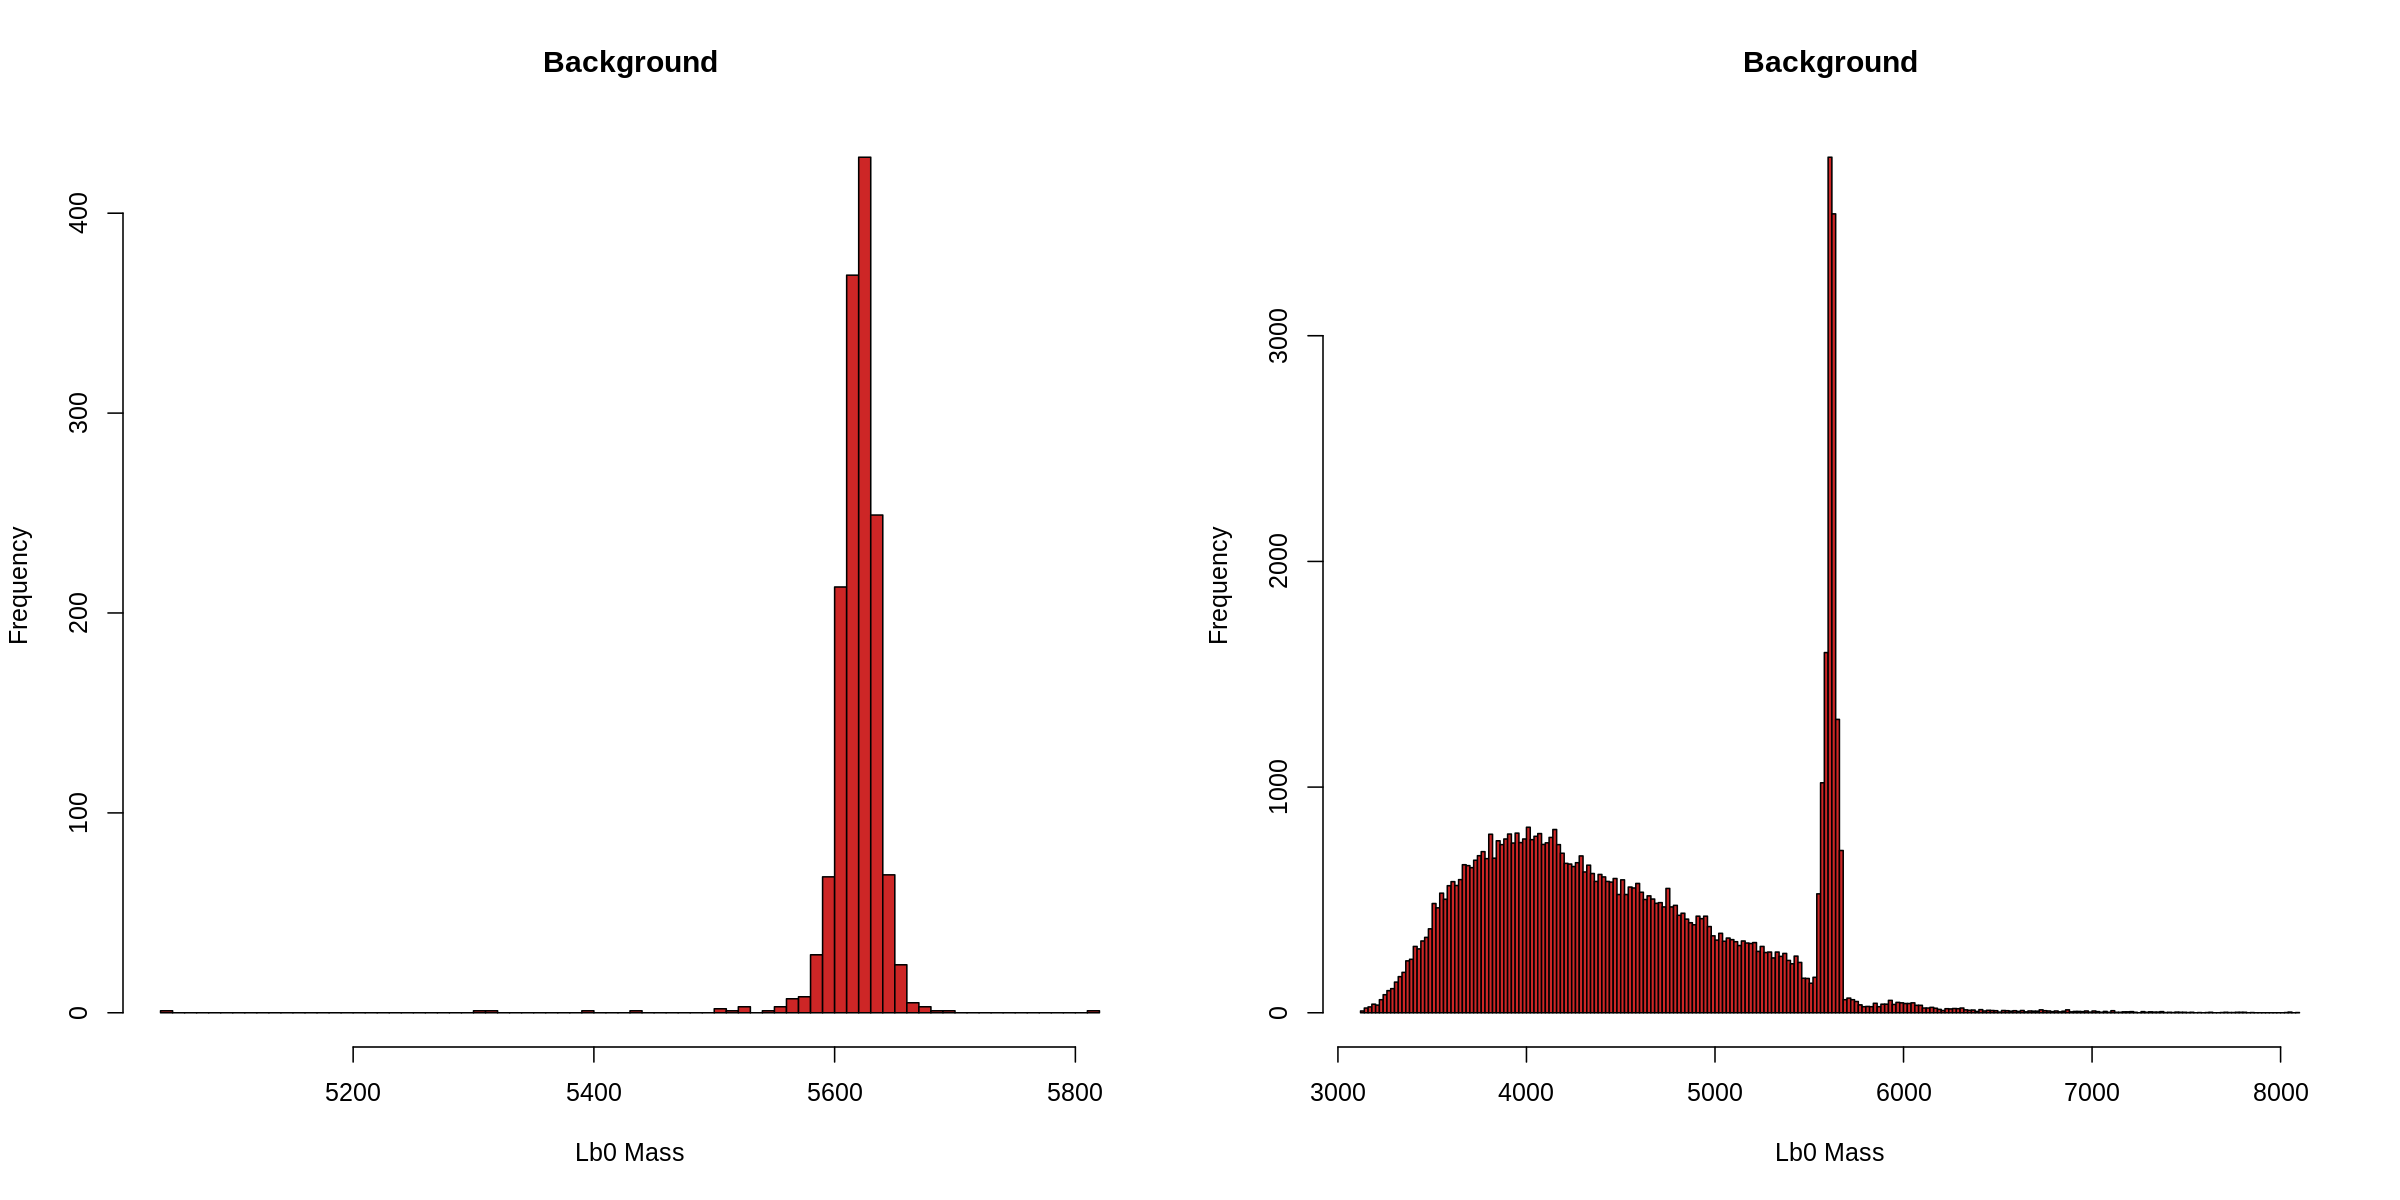

In [141]:
par(mfrow=c(1,2))
options(repr.plot.width=16, repr.plot.height=8, repr.plot.res=150)
hist(data.cutted.sig$Lambda_b0_MM_F, breaks=100, col="firebrick3", xlab="Lb0 Mass", main="Background")
#hist(data.cutted.sig$Lambda_b0_MM_F, breaks=100, col="firebrick3", xlab="Lb0 Mass", main="Signal")
hist(data.cutted.lhcb$Lambda_b0_MM_F, breaks=200, col="firebrick3", xlab="Lb0 Mass", main="Background")

| Feature Id | Feature Code                      | Feature Meaning                                      |
| :-:        | :-:                               | :-:                                                  |
| 2          | <b>lcstar_MM_F               </b> | $\Lambda_c^{+*}$ invariant mass                      |
| 3          | <b>Lambda_c_MM_F             </b> | $\Lambda_c^+$ invariant mass                         |
| 4          | <b>Lambda_b0_MM_F            </b> | $\Lambda_b^0$ invariant mass                         |
| 5          | <b>lc_p_ProbNNp_F            </b> | Probability of $\Lambda_c^+p$ identified as a proton |
| 6          | <b>lcZDecLSigma_F            </b> | $\Lambda_c^+$ z decay length over error              |
| 7          | <b>lcstarZDecLSigma_F        </b> | $\Lambda_c^{+*}$ z decay length over error           |
| 8          | <b>lcDecTime_F               </b> | $\Lambda_c^+$ decay time                             |
| 9          | <b>lcstarDecTime_F           </b> | $\Lambda_c^{+*}$ decay time                          |
| 10         | <b>lbDecTime_F               </b> | $\Lambda_b^0$ decay time                             |
| 11         | <b>lcDecVerChi2_F            </b> | $\Lambda_c^+$ decay vertex                           |
| 12         | <b>lcstarDecVerChi2_F        </b> | $\Lambda_c^{+*}$ decay vertex                        |
| 13         | <b>lbDecVerChi2_F            </b> | $\Lambda_b^0$ decay vertex                           |
| 14         | <b>Lambda_b0_DIRA_OWNPV_F    </b> | $\Lambda_b^0$ DIRA of PV                             |
| 15         | <b>DeltaM_F                  </b> | $\Delta M$                                           |
| 16         | <b>pair_lcstar_F             </b> | Pair mass of the two $\pi$ of the $\Lambda_c^{∗+}$   |
| 17         | <b>pair0_3pi_F               </b> | Pair mass of the two $\pi_0$ and $\pi_1$ (???)       |
| 18         | <b>pair1_3pi_F               </b> | Pair mass of the two $\pi_1$ and $\pi_2$ (???)       |
| 19         | <b>Lambda_b0_BKGCAT_F        </b> | ???                                                  |
| 20         | <b>lcstar_BKGCAT_F           </b> | ???                                                  |
| 21         | <b>Lambda_c_BKGCAT_F         </b> | ???                                                  |
| 22         | <b>tau_pion0_ProbNNpi_F      </b> | ???                                                  |
| 23         | <b>tau_pion1_ProbNNpi_F      </b> | ???                                                  |
| 24         | <b>tau_pion2_ProbNNpi_F      </b> | ???                                                  |
| 25         | <b>lcstar_pim_ProbNNpi_F     </b> | ???                                                  |
| 26         | <b>lcstar_pip_ProbNNpi_F     </b> | ???                                                  |
| 27         | <b>Lambda_b0_ENDVERTEX_CHI2_F</b> | ???                                                  |
| 28         | <b>Lambda_c_ENDVERTEX_CHI2_F </b> | ???                                                  |
| 29         | <b>lcstar_ENDVERTEX_CHI2_F   </b> | ???                                                  |

In [169]:
# "lcstar_MM_F", "Lambda_b0_MM_F", "DeltaM_F", "pair_lcstar_F"

# "tau_pion0_ProbNNpi_F", "tau_pion1_ProbNNpi_F", "tau_pion2_ProbNNpi_F", "lcstar_pim_ProbNNpi_F", 
# "lcstar_pip_ProbNNpi_F", "Lambda_b0_ENDVERTEX_CHI2_F", 
# "Lambda_c_ENDVERTEX_CHI2_F", "lcstar_ENDVERTEX_CHI2_F"

# 2    x   lcstar_MM_F               
# 3        Lambda_c_MM_F             
# 4    x   Lambda_b0_MM_F            
# 5        lc_p_ProbNNp_F            
# 6        lcZDecLSigma_F            
# 7        lcstarZDecLSigma_F        
# 8        lcDecTime_F               
# 9        lcstarDecTime_F           
# 10       lbDecTime_F               
# 11       lcDecVerChi2_F            
# 12       lcstarDecVerChi2_F        
# 13       lbDecVerChi2_F            
# 14       Lambda_b0_DIRA_OWNPV_F    
# 15   x   DeltaM_F                  
# 16   x   pair_lcstar_F             
# 17       pair0_3pi_F               
# 18       pair1_3pi_F               
# 19   xxx Lambda_b0_BKGCAT_F        
# 20   xxx lcstar_BKGCAT_F           
# 21   xxx Lambda_c_BKGCAT_F         
# 22   xx  tau_pion0_ProbNNpi_F      
# 23   xx  tau_pion1_ProbNNpi_F      
# 24   xx  tau_pion2_ProbNNpi_F      
# 25   xx  lcstar_pim_ProbNNpi_F     
# 26   xx  lcstar_pip_ProbNNpi_F     
# 27   xx  Lambda_b0_ENDVERTEX_CHI2_F
# 28   xx  Lambda_c_ENDVERTEX_CHI2_F 
# 29   xx  lcstar_ENDVERTEX_CHI2_F   
sel_features <- c(2, 3, 15)
sig_multiply <- 1

In [176]:
tr_frac <- 0.8

# x_train_bkg <- as.matrix(data.bkg[ 1: as.integer(nrow(data.bkg)*tr_frac), sel_features])
# x_train_sig <- as.matrix(data.sig[ 1: as.integer(nrow(data.sig)*tr_frac), sel_features])
# x_test_bkg  <- as.matrix(data.bkg[-1:-as.integer(nrow(data.bkg)*tr_frac), sel_features])
# x_test_sig  <- as.matrix(data.sig[-1:-as.integer(nrow(data.sig)*tr_frac), sel_features])
x_train_bkg <- as.matrix(data.bkg[ 1:1000, sel_features])
x_train_sig <- as.matrix(data.sig[ 1:     ,sel_features])
x_test_bkg  <- as.matrix(data.bkg[-1:-as.integer(nrow(data.bkg)*tr_frac), sel_features])
x_test_sig  <- as.matrix(data.sig[-1:-as.integer(nrow(data.sig)*tr_frac), sel_features])
 

y_train_bkg <- as.vector(matrix(0, nrow=nrow(x_train_bkg), ncol=1))
y_train_sig <- as.vector(matrix(1, nrow=nrow(x_train_sig), ncol=1))
y_test_bkg  <- as.vector(matrix(0, nrow=nrow(x_test_bkg), ncol=1))
y_test_sig  <- as.vector(matrix(1, nrow=nrow(x_test_sig), ncol=1))

x_train <- rbind(x_train_bkg , x_train_sig )
x_test  <- rbind(x_test_bkg  , x_test_sig  )
y_train <-     c(y_train_bkg , y_train_sig )    
y_test  <-     c(y_test_bkg  , y_test_sig  )

if (sig_multiply>1) {
    for (i in 1:sig_multiply) {
        x_train <- rbind(x_train, x_train_sig)
        x_test  <- rbind(x_test , x_test_sig )
        y_train <-     c(y_train, y_train_sig)    
        y_test  <-     c(y_test , y_test_sig )
    }
}

shuffle_train <- sample(nrow(x_train))
shuffle_test  <- sample(nrow(x_test ))

x_train <- x_train[shuffle_train,]
y_train <- y_train[shuffle_train] 
x_test  <- x_test [shuffle_test,]
y_test  <- y_test [shuffle_test] 

#x_train <- array_reshape(x_train, c(nrow(x_train), ncol(x_train)))
#x_test  <- array_reshape(x_test , c(nrow(x_test ), ncol(x_test )))

x_train <- scale(x_train)
x_test  <- scale(x_test )

#x_lhcb <- as.matrix(data.lhcb[, sel_features])
x_lhcb <- as.matrix(data.cutted.lhcb[, sel_features])
x_lhcb <- scale(x_lhcb)

ERROR: Error in parse(text = x, srcfile = src): <text>:8:43: unexpected ','
7: x_train_bkg <- as.matrix(data.bkg[ 1:1000, sel_features])
8: x_train_sig <- as.matrix(data.sig[ 1:     ,
                                             ^


In [177]:

build_model <- function(params){
    model <- keras_model_sequential()
    model %>%
      layer_dense(units = params$unit1, activation = 'relu', 
                  input_shape = c(params$nFeat), 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout1) %>%
      layer_dense(units = params$unit2, activation = 'relu',  
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout2) %>%
      layer_dense(units = params$unit3, activation = 'relu', 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout3) %>%
      #layer_dense(units = params$unit4, activation = 'relu', 
      #            kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      #layer_dropout(rate = params$dropout4) %>%
      #layer_dense(units = params$unit5, activation = 'relu', 
      #            kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      #layer_dropout(rate = params$dropout5) %>%
      layer_dense(units = 1, activation = 'sigmoid')

    model %>% compile(
      loss = 'binary_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
    )
    return(model)
}
myParams <- flags(
    flag_numeric("dropout1", 0.1),
    flag_numeric("dropout2", 0.1),
    flag_numeric("dropout3", 0.1),
    #flag_numeric("dropout4", 0.1),
    #flag_numeric("dropout5", 0.1),
    flag_numeric("unit1", 128),
    flag_numeric("unit2", 64),
    flag_numeric("unit3", 32),
    #flag_numeric("unit4", 16),
    #flag_numeric("unit5", 8),
    flag_numeric("nFeat", ncol(x_train)),
    flag_numeric("l1_coeff", 1e-4),
    flag_numeric("l2_coeff", 1e-5)
)




loss   accuracy 
0.02260174 0.99631780

`geom_smooth()` using formula 'y ~ x'



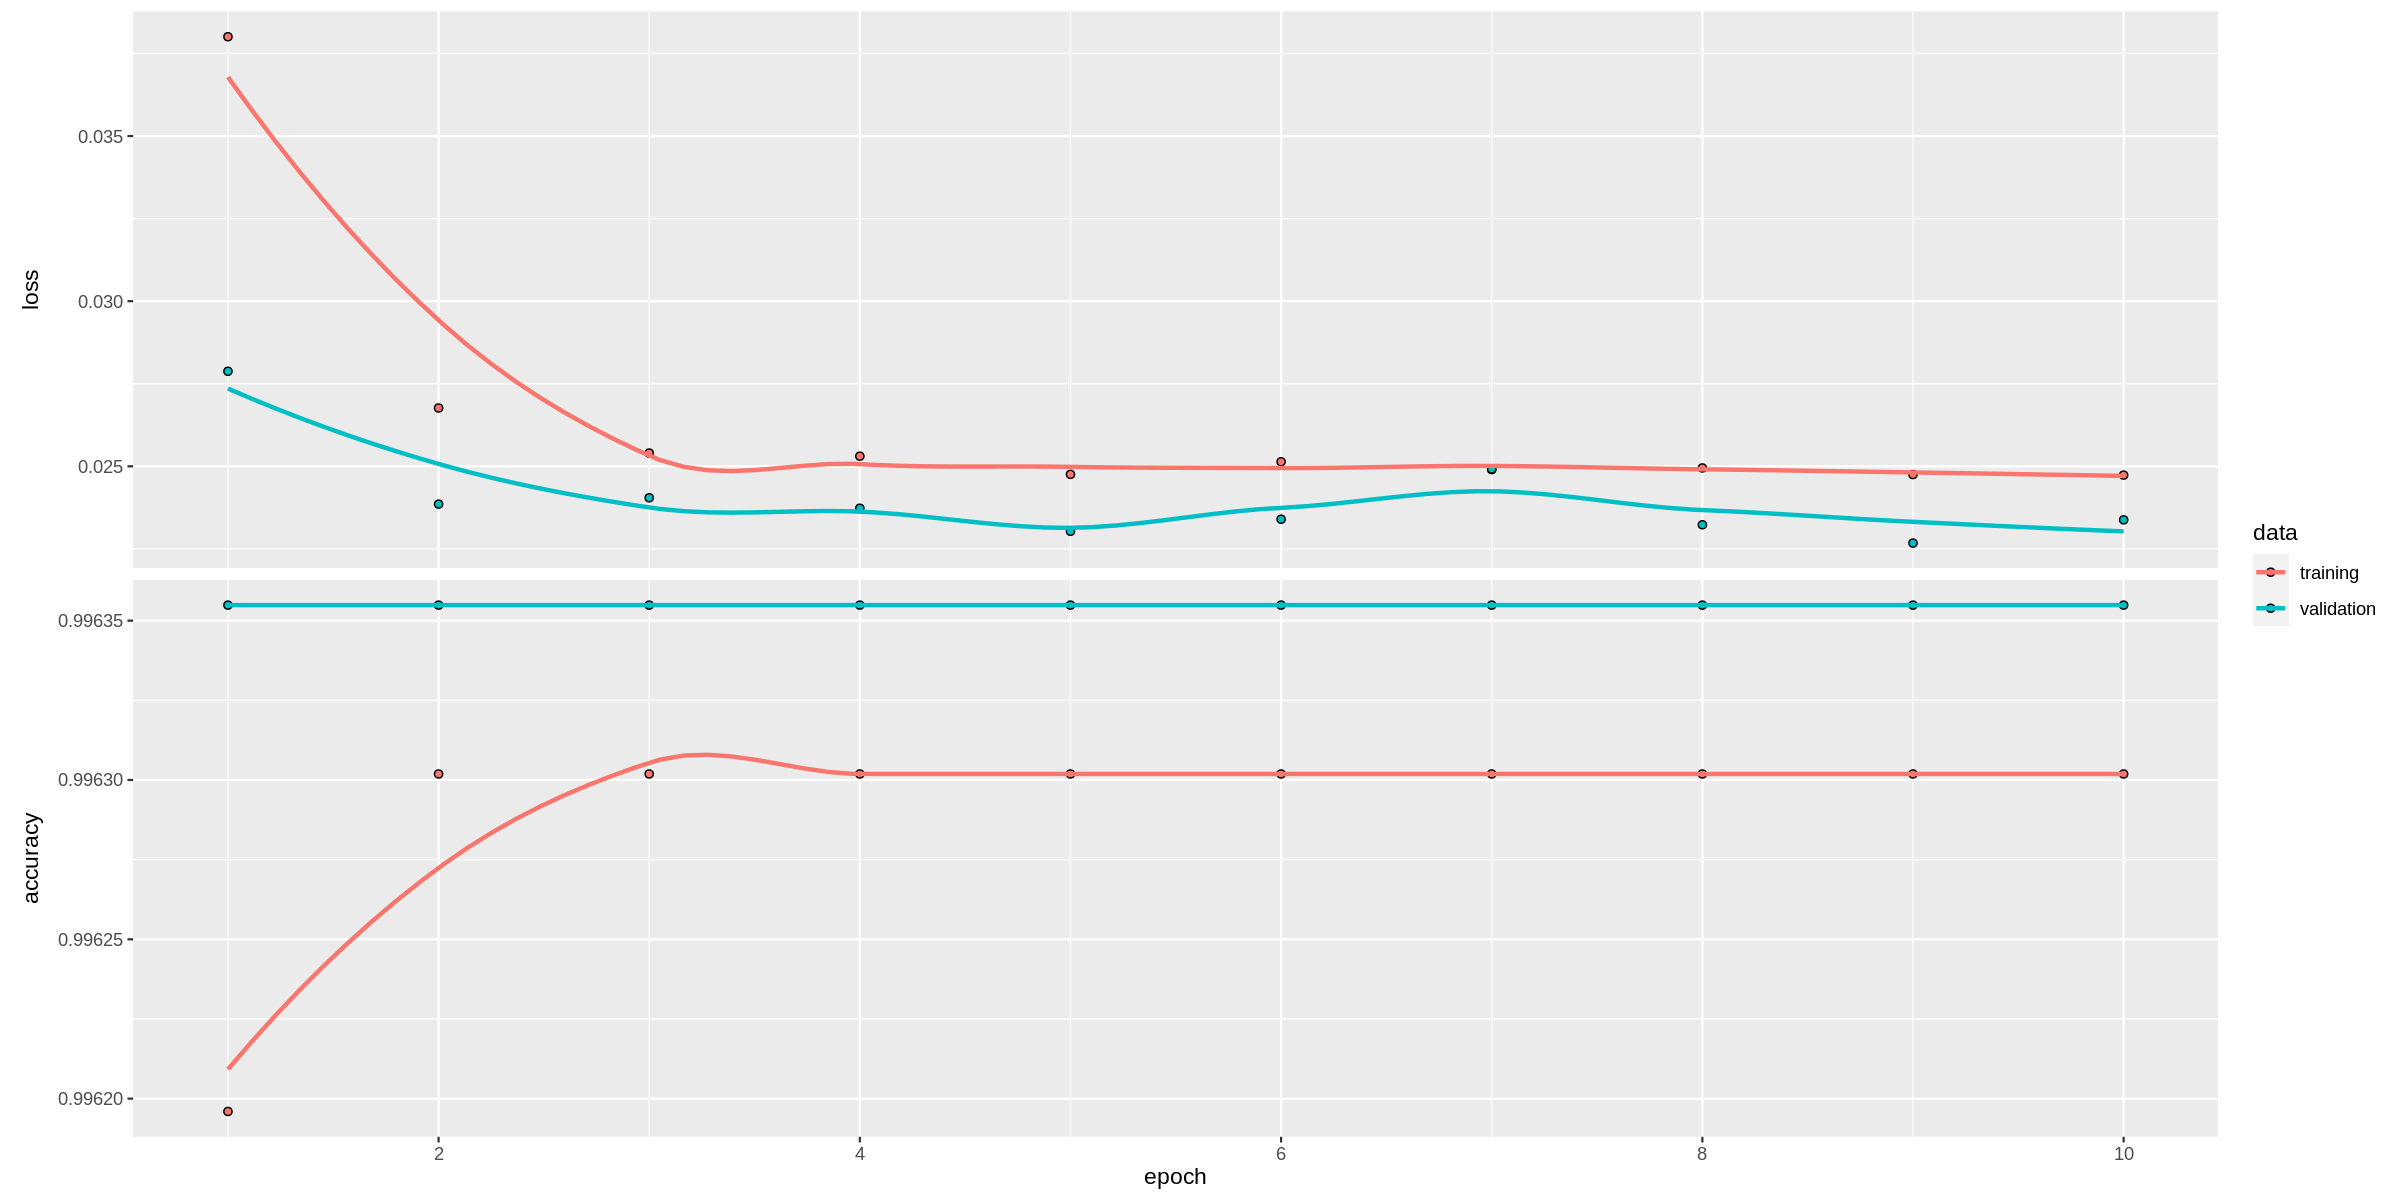

In [178]:
model    <- build_model(myParams)
history  <- model %>% fit (x_train, y_train,  epochs = 10, batch_size = 50, validation_split = 0.3)
model %>% evaluate(x_test, y_test)
plot(history)


In [179]:
y_lhcb <- model %>% predict_classes(x_lhcb) 

In [180]:
unique(y_lhcb)
length(y_lhcb[y_lhcb==0])
length(y_lhcb[y_lhcb==1])

0


[1] 69592

[1] 0

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in hist.default(data.lhcb$Lambda_b0_MM_F[y_lhcb == 1], breaks = 100, : character(0)


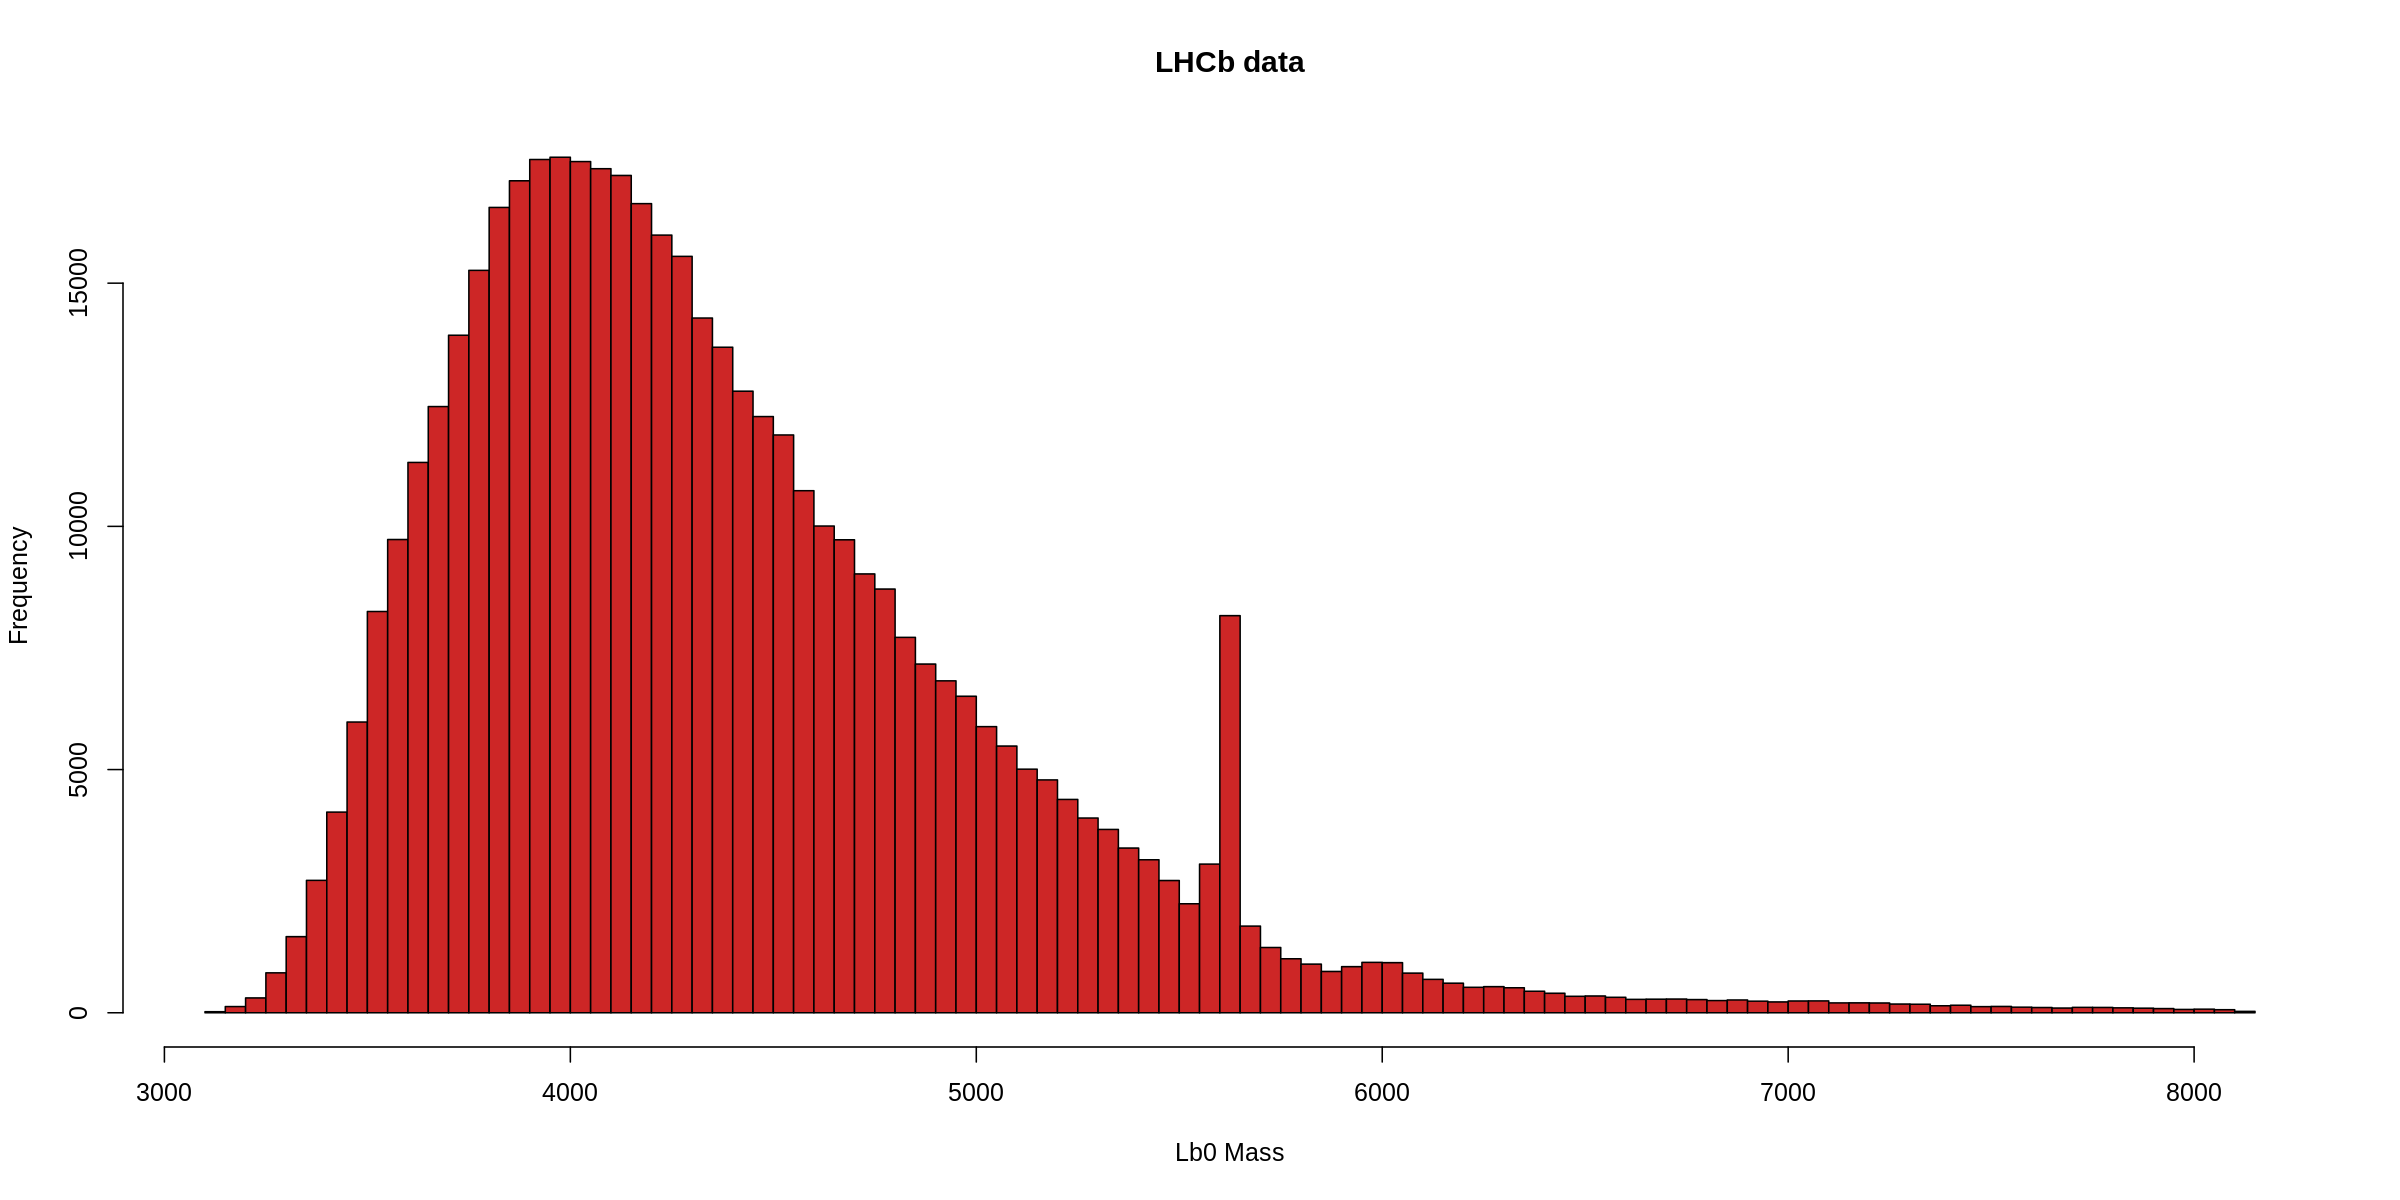

In [162]:
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb==0], breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb==1], breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)

In [85]:
y_lhcb_pred <- model %>% predict(x_lhcb)

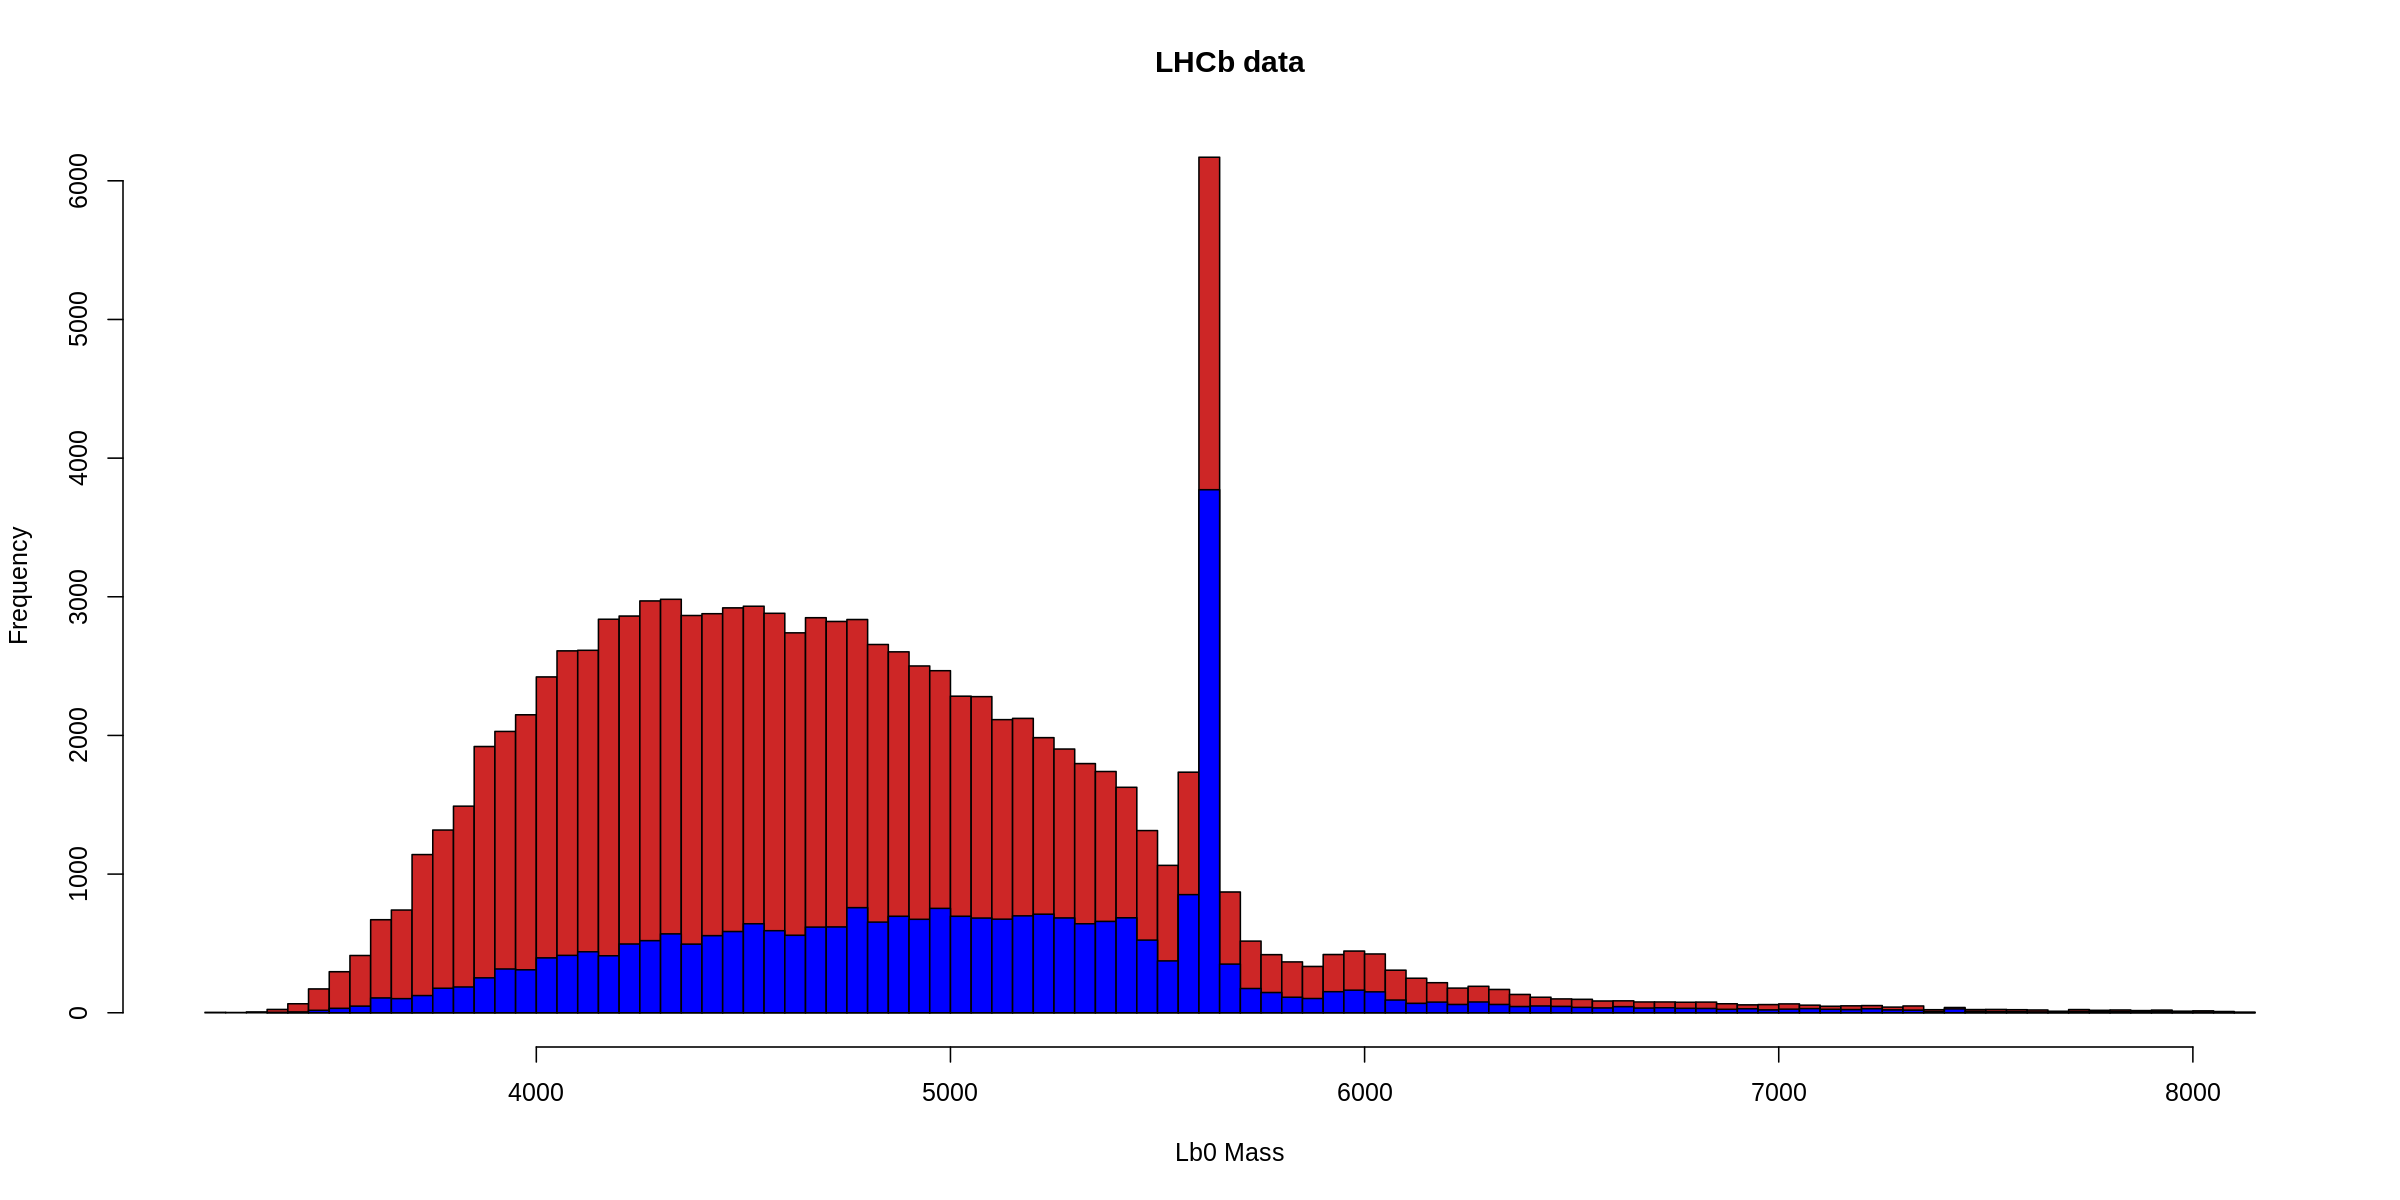

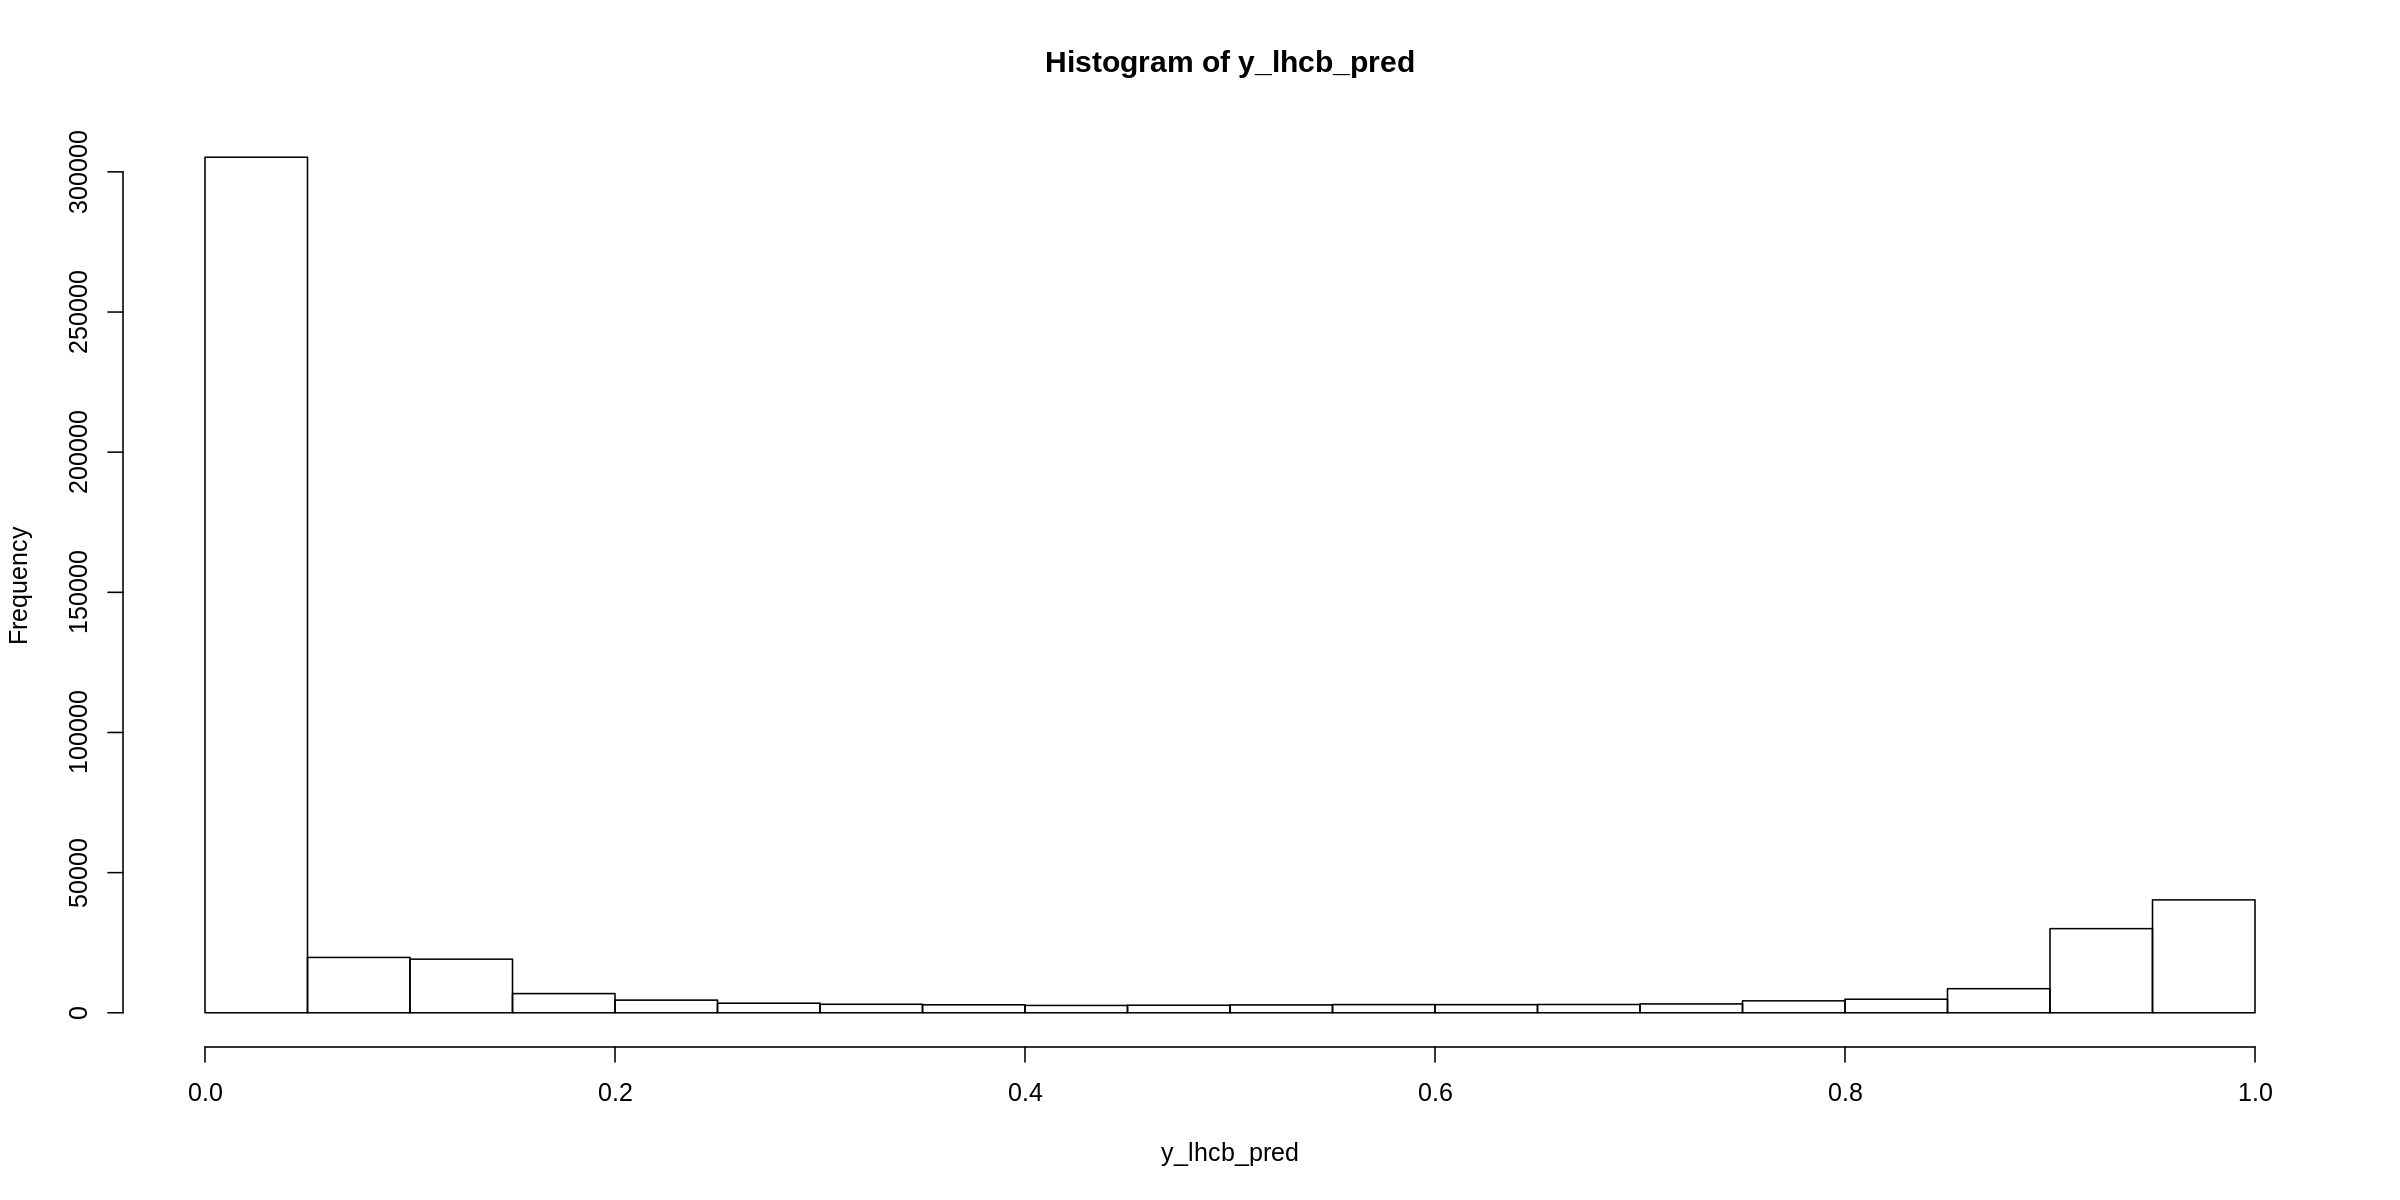

In [88]:
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>0.5], breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>0.97], breaks=100, add=TRUE, col='blue')
hist(y_lhcb_pred)

In [ ]:
#myList <- list(dropout1= c(0.3, 0.2), 
#               unit2=c (128, 64), 
#              epochs= c(3,5))
##myList <- list(dropout1= c(0.3), 
##               unit2=c (128) )
#
#tuned_grid <- tune_builder(build_model, myParams, myList, x_train, y_train, 4, FALSE )
#
#print(tuned_grid)